Lattice light sheet phalloidin (reconstruction)
--------------------------------------

The aim of the analysis is to use 50% of the data as a training set and 50% of the data as the testing set. Since we have very little data, I consider splitting the dataset into to parts (50% top pixels and 50% bottom pixels) and learn a dictionary only on the top pixels. This notebook derives from the notebook `55.Phalloiding dictionary learning`.

Several reconstructions techniques can be investigrated using this notebook, namely:

- Gaussian likelihood
- Poisson likelihood
- Total variation

All those can be tested with either a PSF model or a dictionary.

The notebook is organized as follow:

1. The standalone code
    a. Gaussian likelihood (with a PSF or a dictionary)
    b. Poisson likelihood (with a PSF or a dictionary)
    c. Total variation (with a PSF or a dictionary)
    
2. Code to be run on a computing cluster (using the best of the assessed methods)

Again, analyses of the output are provided in a following notebook (`5b.Lattice light sheet phalloidin (reconstruction)`)

In [3]:
%matplotlib inline
# load stuff
import matplotlib.pyplot as plt
import sys, time, os
import spams
import numpy as np
from libtiff import TIFF, TIFFfile
from sklearn.feature_extraction.image import extract_patches
sys.path.append("../../3_code/")
import cstools
reload(cstools)

<module 'cstools' from '../../3_code/cstools.pyc'>

In [4]:
n_mes = 0
train_size = 128
patch_width = 20
compute_dict = False ## If True, the dictionary is learned again.

# Define paths
bn = "../../4_data/lattice-lightsheet/"
p_psf = os.path.join(bn, "161013_cstest/eyefullfov20um.tif")
p_eye = os.path.join(bn, "10182016_phal_cs/cell1/eyemat_200ms_20um_CamB_ch0_stack0000_1nm_0000000msec_0004907557msecAbs.tif")
p_fou = os.path.join(bn, "10182016_phal_cs/cell1/f_1stlineoff_200ms_CamB_ch0_stack0000_1nm_0000000msec_0005398464msecAbs.tif")
p_dic = "../../5_outputs/20161209_lattice_dict2D/161209_2Ddict_3000.npy"

# useful function
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)
def spiral_tv(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, penalty='tv')

# load data
eye = cstools.read_tif(p_eye, div2=True)
fou_f = cstools.read_tif(p_fou, div2=True, offset2=True)
psf_f = cstools.read_tif(p_psf, div2=True)

# Generate basis
if n_mes == 0:
    b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
else:
    b=cstools.generate_fourier_basis(101, n_mes+1, sample=False, oldmethod=True)
    fou = fou[:,:,:n_mes]
    
# Training/testing set
tra = eye[train_size:,:,:]
fou = fou_f[:train_size,:,:]

In [5]:
patch_size = (1,patch_width,tra.shape[2])
patches=extract_patches(tra, patch_size)
magnitude = []
patches_flat = np.zeros((patches.shape[0]*patches.shape[1], patches.shape[4], patches.shape[5]))
patches_flatflat = np.zeros((patches.shape[0]*patches.shape[1], patches.shape[4]*patches.shape[5]))
k = 0
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        p = patches[i,j,0,0,:,:]
        magnitude.append((p**2).sum())
        patches_flat[k,:,:]=p
        patches_flatflat[k,:] = p.flatten()
        k += 1
        
magnitude = np.array(magnitude)
patches_high = patches_flat[magnitude>np.percentile(magnitude, 60),:,:] ## Keep top 15%
patches_highflat = patches_flatflat[magnitude>np.percentile(magnitude, 60),:] ## Keep top 15%

A few patches (before flattening)


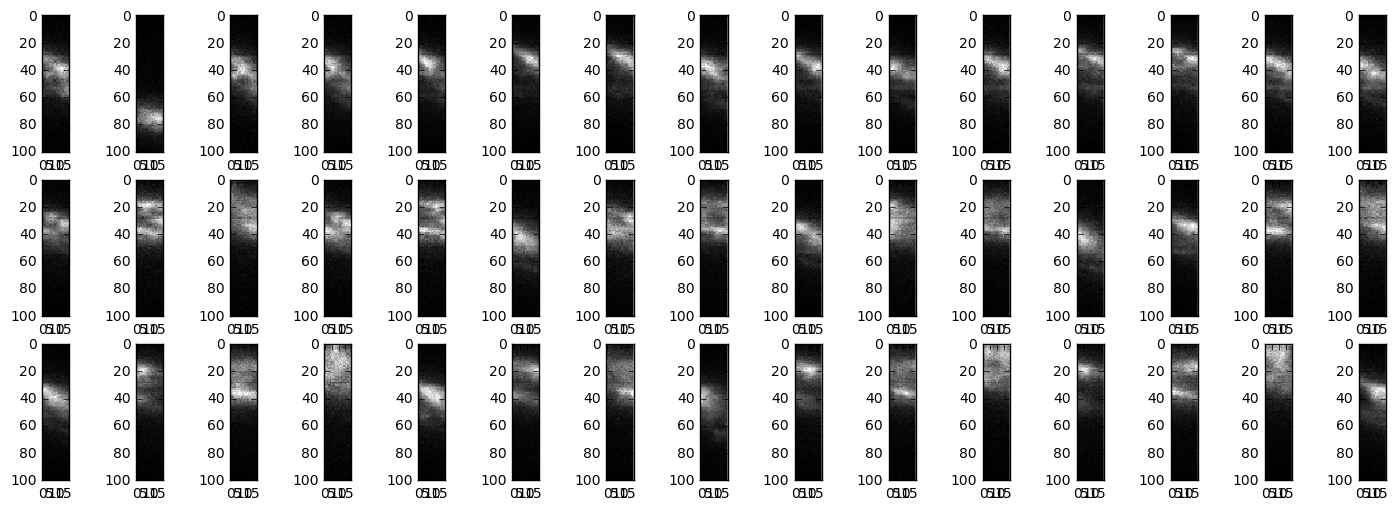

In [6]:
plt.figure(figsize=(18,6))
for (i,p) in enumerate(patches_high[:45]):
    plt.subplot(3,15,i+1)
    plt.imshow(patches_high[75*i].T, cmap='gray', interpolation='none')
print "A few patches (before flattening)"

In [7]:
# Learn a dictionary on that. (Keep 20%)
if compute_dict:
    paramTrain = {'K' : 6000, 'numThreads' : 30, 'iter' : 30}
    X=np.asfortranarray(np.float_(patches_highflat).T)

    print "Starting learning procedure, please be patient."
    tic = time.time()
    D = spams.nmf(X,**paramTrain)
    toc = time.time()
 
    print "Dictionary learning performed in {} s".format(toc-tic) # Took 7 hrs for a dict. with 3000 atoms (and 4551 pixels/atom)
    np.save(p_dic, D)
else:
    print "Loading the dictionary, no need to recompute it"
    D = np.load(p_dic)

A few learned patches (before flattening). There are 6000 patches in the dictionary


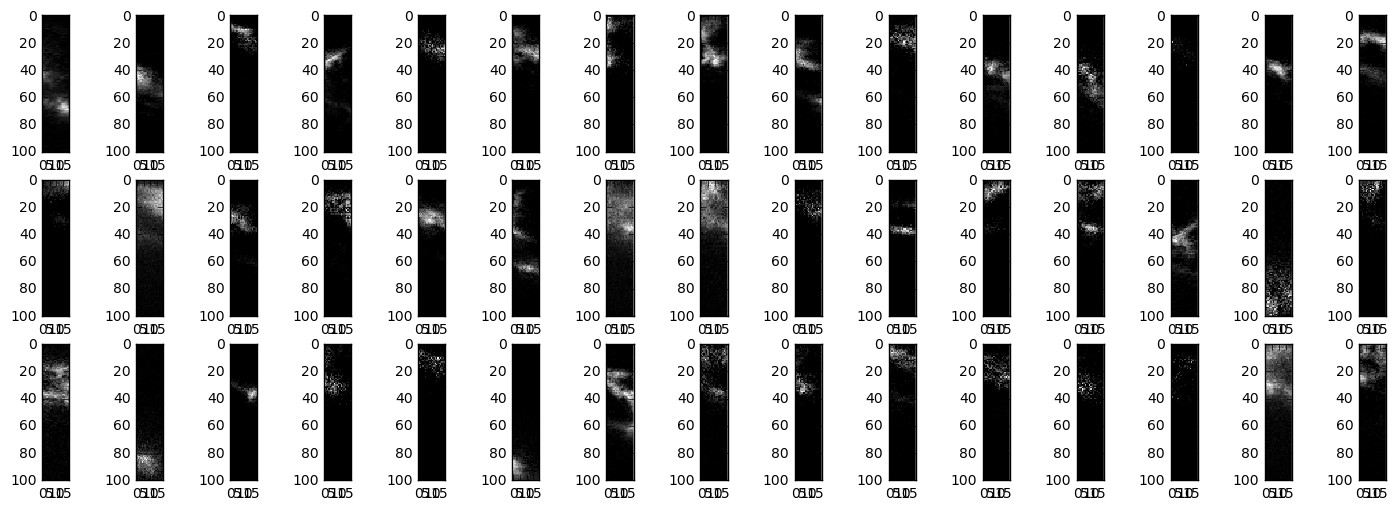

In [8]:
# Show the patches after learning
plt.figure(figsize=(18,6))

for i in range(D.shape[0])[:45]:
    plt.subplot(3,15,i+1)
    plt.imshow(D[:,i].reshape(patch_width, -1).T, cmap='gray', interpolation='none')
print "A few learned patches (before flattening). There are {} patches in the dictionary".format(D.shape[1])

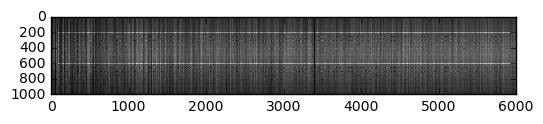

In [9]:
B = cstools.build_2dmodel(b, np.ones(patch_width)).dot(D)

plt.imshow(B, cmap='gray', interpolation='none')

# Reconstructions with a dictionary

In [14]:
# ==== 3. Subdivide the simulated image & reconstruct (with sliding windows)
def reco_image2(ima, verbose=True, solver=spiral):
    im = np.zeros((ima.shape[0], b.shape[1]))
    vec_counts = np.zeros(ima.shape[0])
    for i in range(eye[0, :,:].shape[0]):
        if verbose and i%100 == 0:
            print "-- {}/{}".format(i, eye[0, :,:].shape[0])
        (sta,sto) = (i-patch_width, i)
        im_sub = ima[range(sta,sto),:].flatten()
        #r_sim = spiral2(im_sub, B).reshape((len(psf_xutil),-1))
        r_sim = solver(im_sub, B).dot(D.T).reshape((patch_width, -1))
        im[range(sta,sto),:]+=r_sim
        vec_counts[range(sta,sto)]+=1
        
    for (i,v) in enumerate(vec_counts): # Average each row
        im[i,:] /= v
    return im

In [11]:
im = reco_image2(fou_f[:,78,:], verbose=True)

-- 0/256


/usr/local/lib/python2.7/dist-packages/pySPIRALTAP-0.4.12-py2.7.egg/pySPIRALTAP/pySPIRALTAP.py:212: RuntimeWarning: divide by zero encountered in double_scalars


-- 100/256
-- 200/256


In [15]:
im_poi = reco_image2(fou_f[:,78,:], verbose=True, solver=spiral2)
im_tv  = reco_image2(fou_f[:,78,:], verbose=True, solver=spiral_tv)

-- 0/256
-- 100/256
-- 200/256
-- 0/256


/usr/local/lib/python2.7/dist-packages/pySPIRALTAP-0.4.12-py2.7.egg/pySPIRALTAP/denoise_bound.py:166: RuntimeWarning: invalid value encountered in double_scalars


-- 100/256
-- 200/256


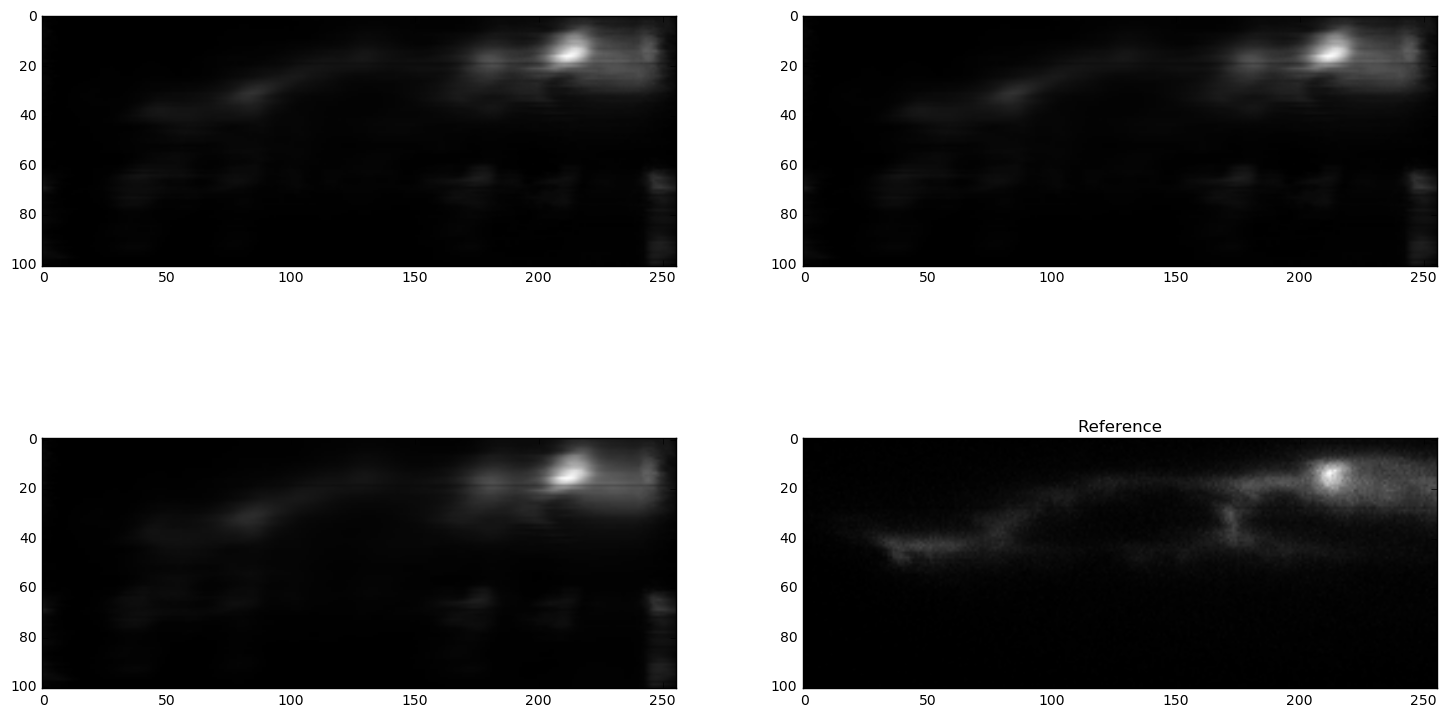

In [17]:
plt.figure(figsize=(18,10))
plt.subplot(221)
plt.imshow(im.T[::-1,:], cmap='gray')
plt.subplot(222)
plt.imshow(im_poi.T[::-1,:], cmap='gray')
plt.subplot(223)
plt.imshow(im_tv.T[::-1,:], cmap='gray')
plt.subplot(224)
plt.imshow(eye[:,78,:].T, cmap='gray')
plt.title("Reference")

# Reconstruction with a PSF model only

In [27]:
## 1. Extract a PSF
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../../5_outputs/psf_models/lattice_161114" ## Set to None to avoid saving
load_psf = True ## Load the PSF from the save_psf file.

step = 8 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.
psf_x = 205
psf_y = range(363, 367)
psf_z = (82, 95)

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)
else:
    psf = eye.mean(0)[psf_y,psf_z[0]:psf_z[-1]].T
    psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))
else:
    print "Not saving the PSF"

if not psfz_ok:
    plt.imshow(psf, cmap='gray', interpolation="none")
elif not psfx_ok:
    psf_xutil = psf.mean(1)
    plt.plot(psf_xutil)
else:
    l=np.zeros((eye.shape[2], 2*psf.shape[1]))
    l[:psf.shape[0],:psf.shape[1]]=psf
    ll=[]
    for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
        for k in range(2*psf.shape[0]):
            ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])
    
    D1 = np.hstack(ll) ## This is the dictionary.
    D2_psf = np.hstack([i.T.reshape((-1,1)) for i in ll])

B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2_psf)
patch_width = psf.shape[1]

Loaded PSF from file ../../5_outputs/psf_models/lattice_161114.npy
Not saving the PSF


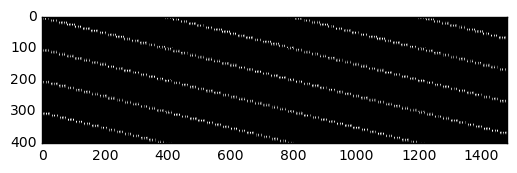

In [22]:
plt.imshow(D2_psf, cmap='gray', interpolation='none')

In [30]:
# ==== 3. Subdivide the simulated image & reconstruct (with sliding windows)
def reco_image_psf(ima, verbose=True, solver=spiral):
    im = np.zeros((ima.shape[0], b.shape[1]))
    vec_counts = np.zeros(ima.shape[0])
    for i in range(eye[0, :,:].shape[0]):
        if verbose and i%100 == 0:
            print "-- {}/{}".format(i, eye[0, :,:].shape[0])
        (sta,sto) = (i-patch_width, i)
        im_sub = ima[range(sta,sto),:].flatten()
        #r_sim = spiral2(im_sub, B).reshape((len(psf_xutil),-1))
        r_sim = solver(im_sub, B).dot(D2_psf.T).reshape((patch_width, -1))
        im[range(sta,sto),:]+=r_sim
        vec_counts[range(sta,sto)]+=1
        
    for (i,v) in enumerate(vec_counts): # Average each row
        im[i,:] /= v
    return im

In [34]:
#im = reco_image_psf(fou_f[:,78,:], verbose=True)
im_poi = reco_image_psf(fou_f[:,78,:], verbose=True, solver=spiral2)
im_tv = reco_image_psf(fou_f[:,78,:], verbose=True, solver=spiral_tv)
## Also try with other solvers

-- 0/256
-- 100/256
-- 200/256
-- 0/256
-- 100/256
-- 200/256


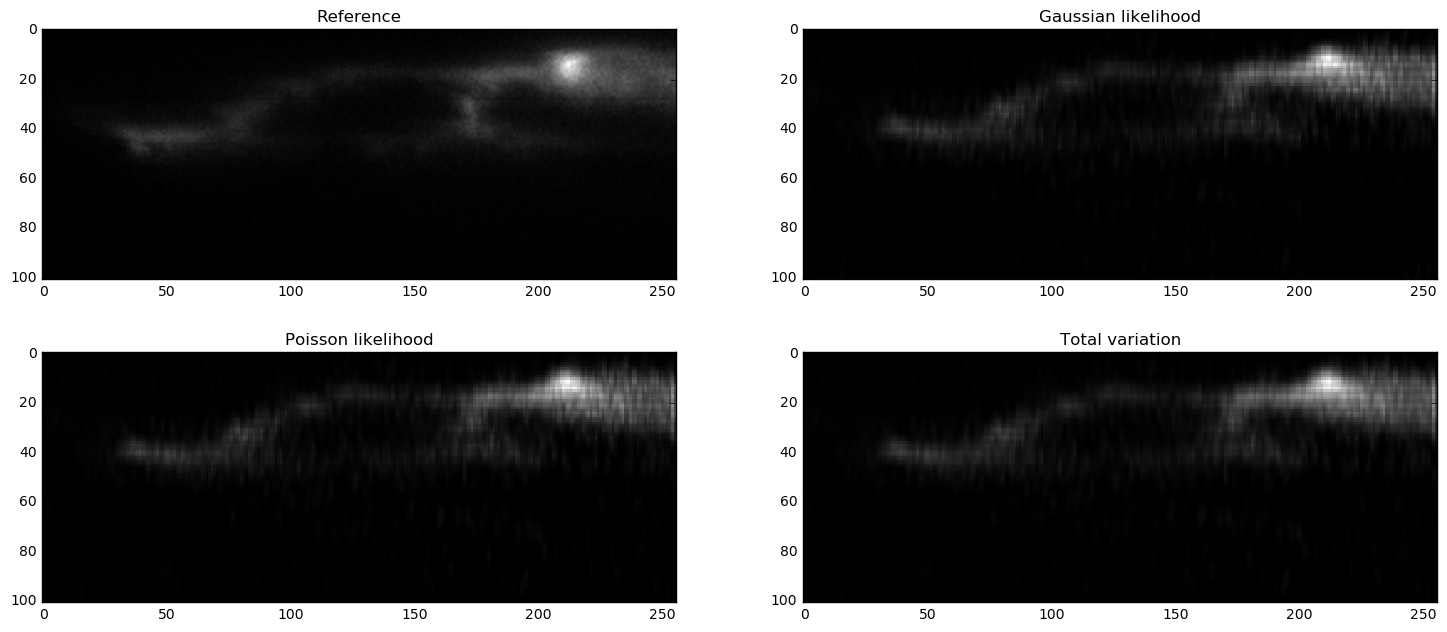

In [41]:
plt.figure(figsize=(18,16))
plt.subplot(421);plt.imshow(eye[:,78,:].T, cmap='gray');plt.title("Reference")
plt.subplot(422);plt.imshow(im.T[::-1,:], cmap='gray', interpolation='none');plt.title("Gaussian likelihood")
plt.subplot(423);plt.imshow(im_poi.T[::-1,:], cmap='gray', interpolation='none');plt.title("Poisson likelihood")
plt.subplot(424);plt.imshow(im_tv.T[::-1,:], cmap='gray', interpolation='none');plt.title("Total variation")

# A cluster-ready version
## How to use it?

1. Copy the code in the appropriate directory (`../8_cluster/tars/09_lattice_phalloidin/`)
2. Copy the data to the right paths
3. Log on `tars`

```{shell}
mkdir ../5_outputs/12_reconstructions_march_phalloidin ## Create the output folder
module load Python/2.7.11

## Progressive test procedure
srun -c 12 --qos=fast -p common,dedicated ~/.envs/dict-optim/bin/python ../8_cluster/tars/09_lattice_phalloidin/reconstruction5.py 0 

```

4. Launch the real reconstructions: `./../8_cluster/tars/09_lattice_phalloidin/reconstruction5.sh`
5. Recombine the images in a TIFF file: `python ../8_cluster/tars/09_lattice_phalloidin/recombine.py rec ../5_outputs/12_reconstructions_march_phalloidin/`

## The code

There is one critical parameter that was varied to generate Figure 4. This parameter is the number of measurements to take into account for the reconstruction: change the `n_mes` variable accordingly (was tuned from 2 to 50, corresponding to a compression/speedup of 2 to 50).

In [52]:
%%writefile ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5.sh
#!/bin/sh
## /!\ This code is generated by a Jupyter script, do not edit it directly.
## It is designed to run reconstructions on a very specific dataset.
## It should be adapted carefully before playing on the input stuff

echo "==== DISCLAIMER ===="
echo "Have you installed the following packages?: virtualenv, numpy, scipy libtiff, joblib, pycsalgos, h5py, pySPIRALTAP"
echo "Have you run the following commands to load the packages?"
echo "$ module load Python/2.7.11"
echo "$ source ~/.local/bin/virtualenvwrapper.sh"
echo "$ export WORKON_HOME=~/.envs"
echo "$ workon dict-optim"

N_FRAMES_IN_STACK=256
email="maxime.woringer@pasteur.fr"
maxparalleljobs=100

echo 'Running on tars'
sbatch --mail-type=BEGIN,END --mail-user=$email --array=0-$N_FRAMES_IN_STACK%$maxparalleljobs ../8_cluster/tars/09_lattice_phalloidin/reconstruction5_init.sh

Overwriting ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5.sh


In [44]:
%%writefile ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5_init.sh
#!/bin/sh
#SBATCH --qos=fast 
#SBATCH -N 1
#SBATCH -c 12
#SBATCH -p common,dedicated
#SBATCH -o ../8_cluster/tars/09_lattice_phalloidin/log_reconstruction.log -e ../8_cluster/tars/09_lattice_phalloidin/log_reconstruction.err
# By Maxime W., Nov. 2016, GPLv3+
# /!\ DO NOT EDIT THIS FILE. IT HAS BEEN GENERATED BY A SCRIPT
# Script is ../2_simulations/51. ...ipynb

## This script to be called by SBATCH, do not call it directly, it will not work.
srun ~/.envs/dict-optim/bin/python ../8_cluster/tars/09_lattice_phalloidin/reconstruction5.py ${SLURM_ARRAY_TASK_ID}

Writing ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5_init.sh


In [54]:
%%writefile ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5.py

import sys, os
import numpy as np
from libtiff import TIFF
sys.path.append("../3_code/")
import cstools
#reload(cstools)

n_mes = 10 ## Compression factor (a number of frames)
save_prefix = "phalloidin{}".format(n_mes)


## tars-specific parameters
frame_to_reconstruct = int(sys.argv[1])


# useful function
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)

# Define paths
bn = "../4_data/lattice-lightsheet/"
p_psf = os.path.join(bn, "161013_cstest/eyefullfov20um.tif")
p_eye = os.path.join(bn, "10182016_phal_cs/cell1/eyemat_200ms_20um_CamB_ch0_stack0000_1nm_0000000msec_0004907557msecAbs.tif")
p_fou = os.path.join(bn, "10182016_phal_cs/cell1/f_1stlineoff_200ms_CamB_ch0_stack0000_1nm_0000000msec_0005398464msecAbs.tif")
#p_dic = "../../5_outputs/20161209_lattice_dict2D/161209_2Ddict_3000.npy"

out_folder = "../5_outputs/12_reconstructions_march_phalloidin"

## Do not reconstruct if we already have it
if os.path.exists(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct))):
    print "reconstruction {} exists, aborting".format("{}.{}.txt".format(save_prefix, frame_to_reconstruct))
    sys.exit(0)

# load data
eye = cstools.read_tif(p_eye, div2=True)
fou_f = cstools.read_tif(p_fou, div2=True, offset2=True)
psf_f = cstools.read_tif(p_psf, div2=True)

fou = fou_f

# Generate basis
if n_mes == 0:
    b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
else:
    b=cstools.generate_fourier_basis(101, n_mes+1, sample=False, oldmethod=True)
    fou = fou[:,:,:n_mes]
    
# Training/testing set
#tra = eye[train_size:,:,:]
#fou_f[:train_size,:,:] ## We perform a full-size reconstruction

###
### ===================== Extract a PSF and build measurement matrix
###
## 1. Extract a PSF
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../5_outputs/psf_models/lattice_161114" ## Set to None to avoid saving
load_psf = True ## Load the PSF from the save_psf file.

step = 8 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.
psf_x = 205
psf_y = range(363, 367)
psf_z = (82, 95)

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)
else:
    psf = eye.mean(0)[psf_y,psf_z[0]:psf_z[-1]].T
    psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))
else:
    print "Not saving the PSF"

if not psfz_ok:
    plt.imshow(psf, cmap='gray', interpolation="none")
elif not psfx_ok:
    psf_xutil = psf.mean(1)
    plt.plot(psf_xutil)
else:
    l=np.zeros((eye.shape[2], 2*psf.shape[1]))
    l[:psf.shape[0],:psf.shape[1]]=psf
    ll=[]
    for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
        for k in range(2*psf.shape[0]):
            ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])
    
    D1 = np.hstack(ll) ## This is the dictionary.
    D2_psf = np.hstack([i.T.reshape((-1,1)) for i in ll])

patch_width = psf.shape[1]
    
###
### ======================== Generate stuff
###
B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2_psf)


## Apply the 2D model
# ==== 3. Subdivide the simulated image & reconstruct (with sliding windows)
def reco_image_psf(ima, verbose=True, solver=spiral):
    im = np.zeros((ima.shape[0], b.shape[1]))
    vec_counts = np.zeros(ima.shape[0])
    for i in range(eye[0, :,:].shape[0]):
        if verbose and i%100 == 0:
            print "-- {}/{}".format(i, eye[0, :,:].shape[0])
        (sta,sto) = (i-patch_width, i)
        im_sub = ima[range(sta,sto),:].flatten()
        #r_sim = spiral2(im_sub, B).reshape((len(psf_xutil),-1))
        r_sim = solver(im_sub, B).dot(D2_psf.T).reshape((patch_width, -1))
        im[range(sta,sto),:]+=r_sim
        vec_counts[range(sta,sto)]+=1
        
    for (i,v) in enumerate(vec_counts): # Average each row
        im[i,:] /= v
    return im
###
### =========================== Reconstruction step
###
print "Reconstructing"
im = reco_image_psf(fou[frame_to_reconstruct,:,:], verbose=False) # Launch a full stack reconstruction

###
### =========================== Saving step
###
np.savetxt(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct)), im)

Overwriting ../../8_cluster/tars/09_lattice_phalloidin/reconstruction5.py


# Recombine the .txt file in one .tiff file

Note that the dimensions of the output images are hardcoded (look at `dim1` and `dim2` variables). You might have to transpose the output if your reconstructions are along the wrong dimension).

In [ ]:
%%writefile ../../8_cluster/tars/09_lattice_phalloidin/recombine.py
## Maxime W., Jul 2016, GPLv3+
## This is actually the worker to combine the movie to a 3D stack

# ==== Imports
import sys, os
import numpy as np
from libtiff import TIFF

dim1 = 256
dim2 = 101
scl = 1000 # Multiply by this factor before saving.


print "Saving a stack of {} elements, {} px".format(dim2, dim1)

# ==== Variables
(none, frame_bn, out_dir) = sys.argv
tmp_dir = os.path.join(out_dir, '')
out_file = os.path.join(out_dir, "{}.tif".format(frame_bn))
remove_neg = True # if True, negative elements in the reconstruction will be set to zero.

# ==== Checking inputs
## Input files
inp_files = [i for i in os.listdir(tmp_dir) if i.startswith(frame_bn)]
if inp_files == []:
    raise IOError('No files found in {} with name starting with {}. ABORTING'.format(tmp_dir, frame_bn))
    
## Output file
if os.path.isfile(out_file):
    im = TIFF.open(out_file, 'r')
    for i in im.iter_images():
        frame0=i
        break
    im.close()
    if frame0.shape[0] >= len(inp_files):
        print "A TIFF stack already exists and has at least as many pixels as what we"
        print "were aiming to reconstruct. EXITING."
        sys.exit(0)

## ==== Saving image
print('Image dimensions are hardcoded so far. I know this is stupid.')
idx = [int(i.split('.')[-2]) for i in inp_files]
lf = sorted(zip(inp_files, idx), key=lambda x: x[1])
im = np.zeros((len(lf), dim1, dim2))
for (i,j) in enumerate(lf):
    f=np.genfromtxt(os.path.join(tmp_dir, j[0]))
    im[i,:,:]=f.T
print "Loaded {} planes".format(len(lf))

if remove_neg:
    print "Negative elements were set to zero"
    im[im<0]=0 ## Bruteforce.
tif = TIFF.open(out_file, 'w')
tif.write_image(np.array(np.int_(im*scl).swapaxes(2, 0).swapaxes(1,2), dtype=np.uint16))
tif.close()